# IPN annulus map

The Interplanetary Network ([IPN](https://heasarc.gsfc.nasa.gov/W3Browse/all/ipngrb.html)) is a group of spacecrafts that localize gamma-ray bursts (GRBs) based on the arrival time of the event at the location of each space mission. This, as other triangulation methods, results in a localization annulus when only two missions detect the GRB. 

The following function returns a multi-resolution map that approximately describes this localization probability. The strategy is similar to generating a map for a well-localized source, as shown in the [Quick Start](Intro.ipynb)) tutorial. We'll first generate an empty map with high resolution around the approximate region where we need it. Then we'll evaluate a normal distribution (in the radial coordinate) around the middle of the annulus.

In [1]:
import mhealpy as mhp
from mhealpy import HealpixMap,HealpixBase
import numpy as np

def get_annulus_map(theta, phi, radius, sigma):
    """
    Obtain a probability distribution map representing the annulus resulting
    from triangulating data from two observers. The annulus is defined
    by the locations of the circle's center, radius and width.
    
    Args:
        theta: Colatitude of the circle center [rad]
        phi: Longitude if the circle center [rad]
        radius: Angular radius of the circle
        sigma: Circle's width, defined as the standard deviation of a
               radial distribution [rad]
    
    Return:
        HealpixMap
    """
    
    # First, get an equivalent single-resolution order, such that the pixel
    # size is smaller than the annulus width
    
    approx_nside = np.sqrt(4*np.pi/12)/sigma # Pixel size is approximately sqrt(4*pi/12)/nside
    order = int(np.ceil(np.log2(approx_nside))+2)
    
    mEq = HealpixBase(order = order, scheme = 'nested') # "Empty" map

    # Now, get the pixels around the annulus' main circle, which is the only
    # region that needs high resolution. We query the equivalent 
    # to 3 standard deviations around.
    # We use query_disc to get the pixels within the outer and inner bounds. The
    # pixels we want are the intersection between these.
    
    center_vec = mhp.ang2vec(theta, phi)
    
    outer_disc= mEq.query_disc(center_vec, radius = radius + 3*sigma)
    inner_disc = mEq.query_disc(center_vec, radius = radius - 3*sigma)
    
    hires_pix = np.setdiff1d(outer_disc, inner_disc)

    # Next, let mhealpy generate the apropiate mesh for a multi-resolution map 
    # containing these pixels
    
    m = HealpixMap.moc_from_pixels(mEq.nside, hires_pix, nest = mEq.is_nested, density = False)

    # We then initialize all pixels based on a radial normal distribution
    
    for pix in range(m.npix):
        pix_vec = m.pix2vec(pix)
        pix_radius = np.arccos(sum(pix_vec*center_vec))
        m[pix] = np.exp(-(pix_radius - radius)**2/2/sigma**2) * m.pixarea(pix)
    
    # Finally, normalize probability distribution to 1 and return
    m /= sum(m)
    
    return m

Let's use it to create a map and plot it:

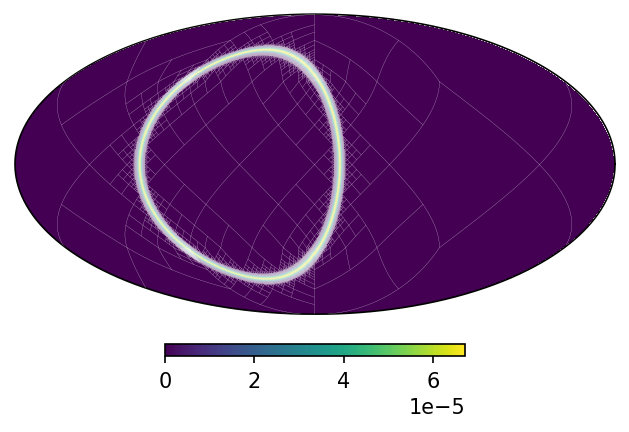

In [2]:
m0 = get_annulus_map(theta = np.deg2rad(90), 
                     phi = np.deg2rad(45), 
                     radius = np.deg2rad(60), 
                     sigma = np.deg2rad(1))

#Plot
import matplotlib.pyplot as plt

m0.plot()
m0.plot_grid(ax = plt.gca(), linewidth = .1, color = 'white', alpha = .5);

Now, let's assume a third spacecraft detected the event and we have an extra constrain that results in a second annulus

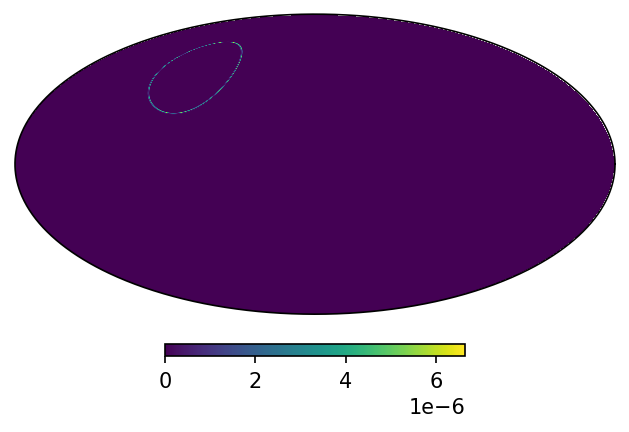

In [3]:
m1 = get_annulus_map(theta = np.deg2rad(45), 
                     phi = np.deg2rad(90), 
                     radius = np.deg2rad(20), 
                     sigma = np.deg2rad(0.1))

m1.plot();

This constrains the source location to approximately two points in the sky

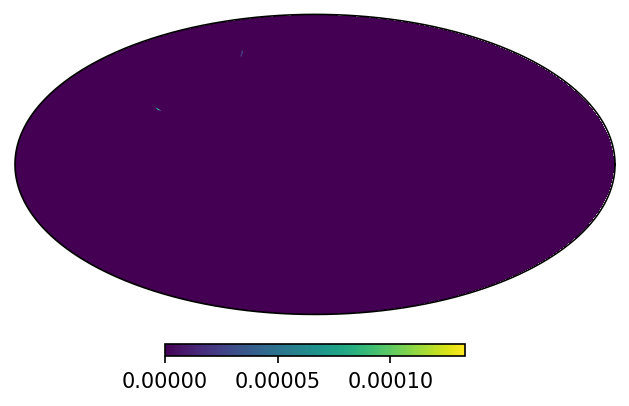

In [4]:
# This divides the value of each pixel by its area, turning the map into a probability density distribution
m0.density(True)
m1.density(True)

mProd = m0*m1

# Return to a probability distribution and normalize
mProd.density(False)
mProd /= sum(mProd)

mProd.plot();

We can see the details by zooming into one of them. It has an elongated shape since one of the annuli was much narrower than the other.

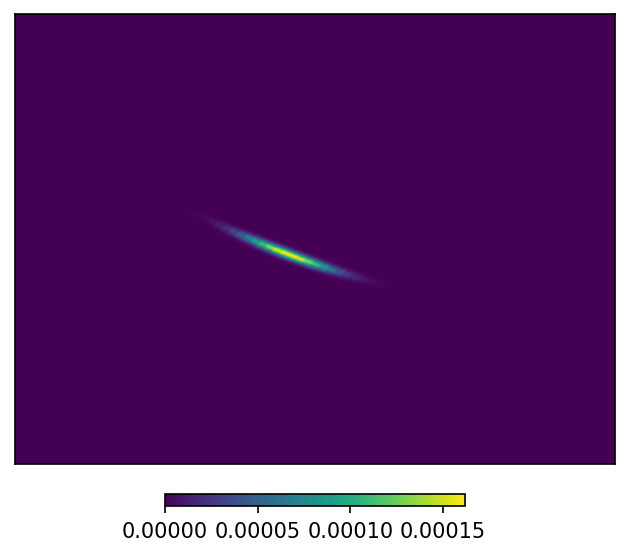

In [5]:
mProd.plot(ax = 'cartview', ax_kw = {'latra':  [20, 35], 'lonra': [90, 110]});